In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_pickle("data/LSWMD.pkl")
df = df.drop(['trianTestLabel'], axis = 1)
df = df.drop(['waferIndex'], axis = 1)

In [3]:
failure_types = []
for f in df.failureType:
    if f.size > 0:
        failure_types.append(f[0][0])
failure_types = set(failure_types)
print('Different failure types:', failure_types)

Different failure types: {'Scratch', 'Near-full', 'Loc', 'Edge-Ring', 'Center', 'Edge-Loc', 'Random', 'Donut', 'none'}


In [4]:
df['failureNum'] = df.failureType
mapping = {'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7, 'none':8}
df=df.replace({'failureNum':mapping})

C:\Users\aeali\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\internals\managers.py:1911: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [5]:
df = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 7)]

Resizing wafer maps

In [6]:
target_dim = 64

In [7]:
def resize_wafer_map(wm, target_size=(target_dim, target_dim)):
    return tf.image.resize(np.expand_dims(wm, axis=-1), target_size, method='nearest').numpy()

In [8]:
def one_hot_img(wm):
    h, w = wm.shape[0], wm.shape[1]
    one_hot = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            one_hot[i, j, int(wm[i, j])] = 1
    return one_hot

In [9]:
def add_noise(wm):
    h, w = wm.shape[0], wm.shape[1] 
    n_change = int(0.01 * h * w)
    changed = 0
    noised = wm.copy()
    while changed < n_change:
        i, j = np.random.randint(0, target_dim), np.random.randint(0, target_dim)
        if wm[i, j, 0] == 0:  # If the point is on the wafer
            noised[i, j, 1] = int(not noised[i, j, 1])
            noised[i, j, 2] = int(not noised[i, j, 2])
            changed += 1
    return noised

In [10]:
df['waferMapResized']=df.waferMap.apply(resize_wafer_map).apply(one_hot_img)

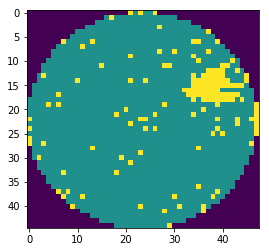

In [11]:
wm = df.waferMap[19]
wm_resized = df.waferMapResized[19]
wm_noised = add_noise(wm_resized)
plt.imshow(wm.squeeze())

(64, 64, 3)


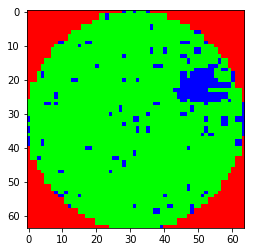

In [12]:
plt.imshow(wm_resized.squeeze())
print(wm_resized.shape)

(64, 64, 3)


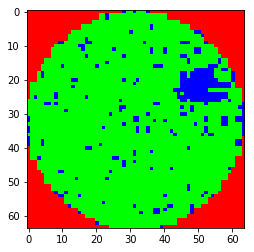

In [13]:
plt.imshow(wm_noised.squeeze())
print(wm_noised.shape)

Stratified sampling with proportionate allocation

In [14]:
for label in range(len(failure_types)):
    globals()['df_{}'.format(label)] = df[(df['failureNum'] == label)].sample(frac=1)

In [15]:
print('Number of samples per class:')
for label in range(len(failure_types) - 1):
    print('{}:'.format(label), len(globals()['df_{}'.format(label)]))

Number of samples per label:
0: 4294
1: 555
2: 5189
3: 9680
4: 3593
5: 866
6: 1193
7: 149


In [16]:
test_ratio, valid_ratio = 0.2, 0.2
for label in range(len(failure_types)):
    length = len(globals()['df_{}'.format(label)])
    idx_test = int(length * test_ratio)
    idx_valid = idx_test + int(length * valid_ratio)
    globals()['df_{}_test'.format(label)] = globals()['df_{}'.format(label)][:idx_test].reset_index()
    globals()['df_{}_valid'.format(label)] = globals()['df_{}'.format(label)][idx_test:idx_valid].reset_index()
    globals()['df_{}_train'.format(label)] = globals()['df_{}'.format(label)][idx_valid:].reset_index()
    del globals()['df_{}'.format(label)]

In [17]:
print('\nNumber of samples per label in test set:')
for label in range(len(failure_types) - 1):
    print('{}:'.format(label), len(globals()['df_{}_test'.format(label)]))

print('\nNumber of samples per label in valid set:')
for label in range(len(failure_types) - 1):
    print('{}:'.format(label), len(globals()['df_{}_valid'.format(label)]))

print('Number of samples per label in train set:')
for label in range(len(failure_types) - 1):
    print('{}:'.format(label), len(globals()['df_{}_train'.format(label)]))


Number of samples per label in test set:
0: 858
1: 111
2: 1037
3: 1936
4: 718
5: 173
6: 238
7: 29

Number of samples per label in valid set:
0: 858
1: 111
2: 1037
3: 1936
4: 718
5: 173
6: 238
7: 29
Number of samples per label in train set:
0: 2578
1: 333
2: 3115
3: 5808
4: 2157
5: 520
6: 717
7: 91


In [18]:
max_class_len_train = np.max([len(globals()['df_{}_train'.format(i)]) for i in range(len(failure_types) - 1)])
print(max_class_len_train)

5808


Data augmentation for the train set

In [19]:
x_test, y_test = [], []
for label in range(len(failure_types) - 1):
    for wm in globals()['df_{}_test'.format(label)].waferMapResized:
        x_test.append(np.expand_dims(wm, axis=0))
        y_test.append(label)

In [20]:
x_valid, y_valid = [], []
for label in range(len(failure_types) - 1):
    for wm in globals()['df_{}_valid'.format(label)].waferMapResized:
        x_valid.append(np.expand_dims(wm, axis=0))
        y_valid.append(label)

In [21]:
x_train, y_train = [], []
for label in range(len(failure_types) - 1):
    length = len(globals()['df_{}_train'.format(label)])
    n_new = max_class_len_train - length
    for i in range(n_new):
        x = globals()['df_{}_train'.format(label)].waferMapResized.loc[np.random.choice(range(length))]
        if np.random.random() < 0.5:
            new_x = tf.image.flip_left_right(x).numpy()
        else:
            new_x = tf.image.rot90(x).numpy()
        new_x = add_noise(new_x)
        x_train.append(np.expand_dims(new_x, axis=0))
        y_train.append(label)
    for wm in globals()['df_{}_train'.format(label)].waferMapResized:
        x_train.append(np.expand_dims(wm, axis=0))
        y_train.append(label)

In [22]:
x_test_arr = np.concatenate(x_test, axis=0)
y_test_arr = np.array(y_test)
x_valid_arr = np.concatenate(x_valid, axis=0)
y_valid_arr = np.array(y_valid)
x_train_arr = np.concatenate(x_train, axis=0)
y_train_arr = np.array(y_train)
del x_test, y_test, x_valid, y_valid, x_train, y_train

In [23]:
y_test_arr = to_categorical(y_test_arr)
y_valid_arr = to_categorical(y_valid_arr)
y_train_arr = to_categorical(y_train_arr)

[0. 1. 0. 0. 0. 0. 0. 0.]


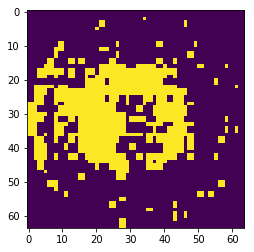

In [24]:
plt.imshow(x_train_arr[11422, :, :, -1].squeeze())
print(y_train_arr[11422])

Model definition

In [68]:
tf.keras.backend.clear_session()

cnn = Sequential()
cnn.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(target_dim, target_dim, 1)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dropout(0.25))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(8, activation='softmax'))

cnn.compile('nadam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [76]:
cb = [EarlyStopping(patience=3)]

In [77]:
history = cnn.fit(np.expand_dims(x_train_arr[:, :, :, 2], axis=-1), y_train_arr, batch_size=1024, epochs=20,
                  validation_data=(np.expand_dims(x_valid_arr[:, :, :, 2], axis=-1), y_valid_arr), callbacks=cb)

Train on 46464 samples, validate on 5100 samples
Epoch 1/20
46464/46464 [==============================] - 553s 12ms/sample - loss: 0.4215 - categorical_accuracy: 0.8379 - val_loss: 0.3357 - val_categorical_accuracy: 0.8663
Epoch 2/20
46464/46464 [==============================] - 468s 10ms/sample - loss: 0.3912 - categorical_accuracy: 0.8509 - val_loss: 0.3258 - val_categorical_accuracy: 0.8673
Epoch 3/20
46464/46464 [==============================] - 400s 9ms/sample - loss: 0.3781 - categorical_accuracy: 0.8562 - val_loss: 0.3065 - val_categorical_accuracy: 0.8749
Epoch 4/20
46464/46464 [==============================] - 435s 9ms/sample - loss: 0.3509 - categorical_accuracy: 0.8678 - val_loss: 0.2886 - val_categorical_accuracy: 0.8788
Epoch 5/20
46464/46464 [==============================] - 417s 9ms/sample - loss: 0.3413 - categorical_accuracy: 0.8709 - val_loss: 0.2648 - val_categorical_accuracy: 0.8927
Epoch 6/20
46464/46464 [==============================] - 377s 8ms/sample - los

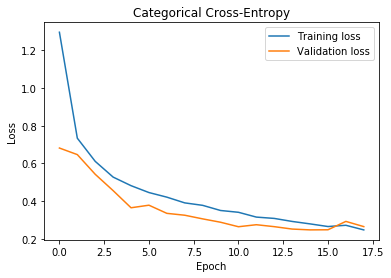

In [82]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Categorical Cross-Entropy')
plt.show()

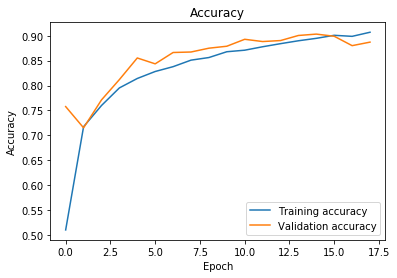

In [83]:
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [84]:
score = cnn.evaluate(np.expand_dims(x_test_arr[:, :, :, 2], axis=-1), y_test_arr, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.26756480153029166
Test accuracy: 0.8905882


In [85]:
predictions = cnn.predict(np.expand_dims(x_test_arr[:, :, :, 2], axis=-1))

In [86]:
cm = confusion_matrix(np.argmax(y_test_arr, axis=1), np.argmax(predictions, axis=1))
cm

array([[ 828,    4,    1,    0,    4,    6,   15,    0],
       [   0,  105,    0,    0,    5,    1,    0,    0],
       [   5,    1,  875,   40,   35,   20,   58,    3],
       [   2,    1,   27, 1898,    2,    1,    5,    0],
       [  24,    7,   49,    0,  436,   10,  192,    0],
       [   0,    2,    2,    0,    1,  167,    1,    0],
       [   1,    1,    9,    2,   18,    1,  206,    0],
       [   2,    0,    0,    0,    0,    0,    0,   27]], dtype=int64)